# London Airbnb Market Analysis: A Spatial Data Science Approach

---

#### 1. Executive Summary
This project utilises **GeoPandas** and **Python** to analyse the London short-term rental market using real-world data from *Inside Airbnb*. By integrating spatial data cleaning, metric projection, and visualissation techniques, we aim to uncover:
1.  **Price Distribution:** Which boroughs command the highest premiums?
2.  **Market Efficiency:** Where is the "sweet spot" between cost and demand?

#### 2. Technical Methodologies
* **Data Cleansing:** Handling dirty real-world datasets (currency conversion, outlier removal).
* **Spatial Engineering:** Coordinate reference system (CRS) transformations (EPSG:4326 to EPSG:3857).
* **Visualisation:** Professional choropleth mapping with `contextily` basemaps and `matplotlib` customisation.

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import contextily as ctx
import matplotlib.patheffects as PathEffects

# --- 1. Load Data from Local File ---
print("Loading local listing data...")

try:
    # Read the locally downloaded CSV file
    df = pd.read_csv("listings.csv")
    
    print(f"Success: Loaded {len(df)} records of real-world housing data.")
    
    # Inspect raw data
    print(df[['name', 'neighbourhood', 'latitude', 'longitude', 'price', 'room_type']].head())

except FileNotFoundError:
    print("❌ Error: 'listings.csv' not found!")
    print("Action Required: Please ensure the downloaded file is in the current directory.")

Loading local listing data...
Success: Loaded 96871 records of real-world housing data.
                                                name            neighbourhood  \
0                Holiday London DB Room Let-on going  Neighborhood highlights   
1                Bright Chelsea  Apartment. Chelsea!  Neighborhood highlights   
2   Very Central Modern 3-Bed/2 Bath By Oxford St W1  Neighborhood highlights   
3                   Battersea live/work artist house  Neighborhood highlights   
4  Bright 1 bedroom apt off brick lane in Shoreditch                      NaN   

   latitude  longitude    price        room_type  
0  51.56861   -0.11270   $70.00     Private room  
1  51.48780   -0.16813  $149.00  Entire home/apt  
2  51.52195   -0.14094  $411.00  Entire home/apt  
3  51.47072   -0.16266      NaN  Entire home/apt  
4  51.52322   -0.06979  $210.00  Entire home/apt  


### 2 Data Cleansing & Pre-processing

Real-world data is rarely "model-ready". The raw `price` column contains currency symbols (`$`, `£`) and commas (e.g., `£1,200.00`), which Python treats as text strings rather than numbers.

* **Regex Cleaning:** We employ regular expressions to strip non-numeric characters.
* **Type Conversion:** Casting strings to floats for mathematical analysis.
* **Outlier Removal:** We filter out erroneous listings (e.g., £0 or >£1000/night) to ensure statistical robustness.

In [29]:
# --- 2. Data Cleansing: Formatting & Geometry Creation ---
print("Cleaning data (Removing currency symbols & converting types)...")

# 1. Critical Step: Clean the 'price' column
# Raw data format examples: "$1,200.00" or "£150.00"
# Strategy: Remove '$', '£', and ',' using Regex
df['price'] = df['price'].astype(str).str.replace(r'[£$,]', '', regex=True)

# 2. Convert to numeric type
# 'coerce' turns unparseable values into NaN (Not a Number)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 3. Handle missing values
df = df.dropna(subset=['price'])

# 4. Spatial Conversion (DataFrame -> GeoDataFrame)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# 5. Filter Outliers
# Retain only listings between £0 and £1000 to avoid skewing the mean
gdf = gdf[(gdf['price'] > 0) & (gdf['price'] < 1000)]

print(f"Post-Cleaning Valid Listings: {len(gdf)}")
print("Data cleansing complete. 'Price' column is now numeric.")
print(gdf['price'].head())

Cleaning data (Removing currency symbols & converting types)...
Post-Cleaning Valid Listings: 61151
Data cleansing complete. 'Price' column is now numeric.
0     70.0
1    149.0
2    411.0
4    210.0
5    280.0
Name: price, dtype: float64


### 3 Acquiring Administrative Boundaries

To aggregate individual listings into meaningful insights, we need the official boundary polygons for London's 33 boroughs.

We implement an **auto-download pattern**. The script checks for a local GeoJSON file; if missing, it automatically fetches the latest boundary data from a stable open-source repository (Code for Germany/Click That Hood). This ensures the project is reproducible on any machine.

Status: Acquiring London borough boundary map...
✅ Success: Local map file found. Loading directly...
Status: Map loaded successfully.
Map Columns: Index(['name', 'cartodb_id', 'created_at', 'updated_at', 'geometry'], dtype='object')
                   name
0  Barking and Dagenham
1                Barnet
2                Bexley


d:\python\envs\spatial_env\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
d:\python\envs\spatial_env\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


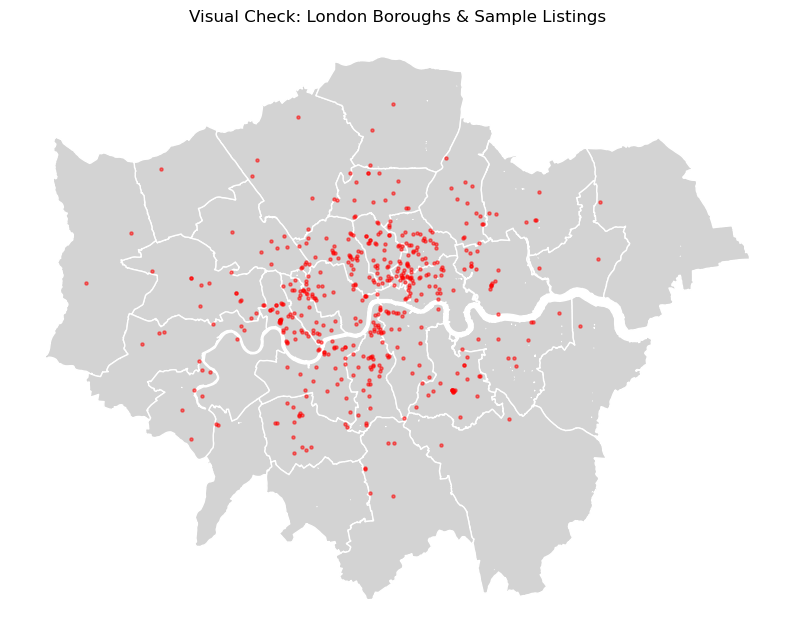

In [30]:
# --- 3. Load London Borough Boundaries (Auto-Download Strategy) ---
print("Status: Acquiring London borough boundary map...")

# Stable data source for London GeoJSON
geojson_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/london.geojson"
local_filename = "london_boroughs.geojson"

# 1. Check if file exists locally
if not os.path.exists(local_filename):
    print("Status: Local map file not found. Downloading...")
    try:
        r = requests.get(geojson_url)
        if r.status_code == 200:
            with open(local_filename, 'wb') as f:
                f.write(r.content)
            print("✅ Success: Map downloaded and saved as 'london_boroughs.geojson'.")
        else:
            print(f"❌ Failure: HTTP Status Code {r.status_code}")
    except Exception as e:
        print(f"❌ Error during download: {e}")
else:
    print("✅ Success: Local map file found. Loading directly...")

# 2. Read the GeoJSON
try:
    boroughs = gpd.read_file(local_filename)
    print("Status: Map loaded successfully.")
    
    # 3. Column Inspection
    # Verifying the column name for borough names (usually 'name')
    print("Map Columns:", boroughs.columns)
    print(boroughs[['name']].head(3))

except Exception as e:
    print(f"❌ Error reading file: {e}")

# 4. Visual Validation
try:
    fig, ax = plt.subplots(figsize=(10, 8))
    boroughs.plot(ax=ax, color='lightgrey', edgecolor='white')
    # Overlay a sample of listings to verify alignment
    if 'gdf' in locals():
        gdf.iloc[:500].plot(ax=ax, color='red', markersize=5, alpha=0.5)
    plt.title("Visual Check: London Boroughs & Sample Listings")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Visualization Error: {e}")

### 4 Spatial Aggregation & Statistical Analysis

To determine the average rental price per borough.

**Process:**
1.  **Column Alignment:** We utilise the `neighbourhood_cleansed` column from the Airbnb dataset, which contains standardized borough names.
2.  **Aggregation:** We group the data by borough and calculate the mean price.
3.  **Merge:** The statistical results are merged with the spatial polygons (GeoJSON) to create a dataset ready for mapping.

In [31]:
# --- 4. Spatial Analysis: Pricing by Borough ---
print("Performing spatial statistical analysis...")

# 1. Verify Columns
print("Dataset Columns:", gdf.columns)

# 2. Grouping & Aggregation
# Using 'neighbourhood_cleansed' as it contains the official borough names
stats = gdf.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
stats.columns = ['name', 'avg_price']

# 3. Merge Statistics with Map Boundaries
# Joining on the 'name' column
london_map = boroughs.merge(stats, left_on='name', right_on='name', how='left')

# 4. Top 5 Most Expensive Areas
top_5 = stats.sort_values(by='avg_price', ascending=False).head(5)
print("\n✅ Insight: Top 5 Most Expensive Boroughs (Average Price per Night):")
print(top_5)

# 5. Data Integrity Check
print("\nMerged Data Preview:")
print(london_map[['name', 'avg_price']].head())

Performing spatial statistical analysis...
Dataset Columns: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'm

In [10]:
%pip install contextily adjustText

Note: you may need to restart the kernel to use updated packages.


### 5 Visualisation - The "Location Premium" Map

This step generates a professional-grade Choropleth map.

* **Basemap Integration:** Using `contextily` to overlay data onto a real street map (CartoDB Positron style) for geographic context.
* **Smart Labelling:** To avoid visual clutter in the dense City Centre, we implement a **Dictionary Mapping** technique to abbreviate long borough names (e.g., "Kensington and Chelsea" $\rightarrow$ "K&C").
* **Visual Hierarchy:** Labels are applied only to the top 6 most expensive boroughs to maintain focus.

Generating professional map with abbreviated labels...


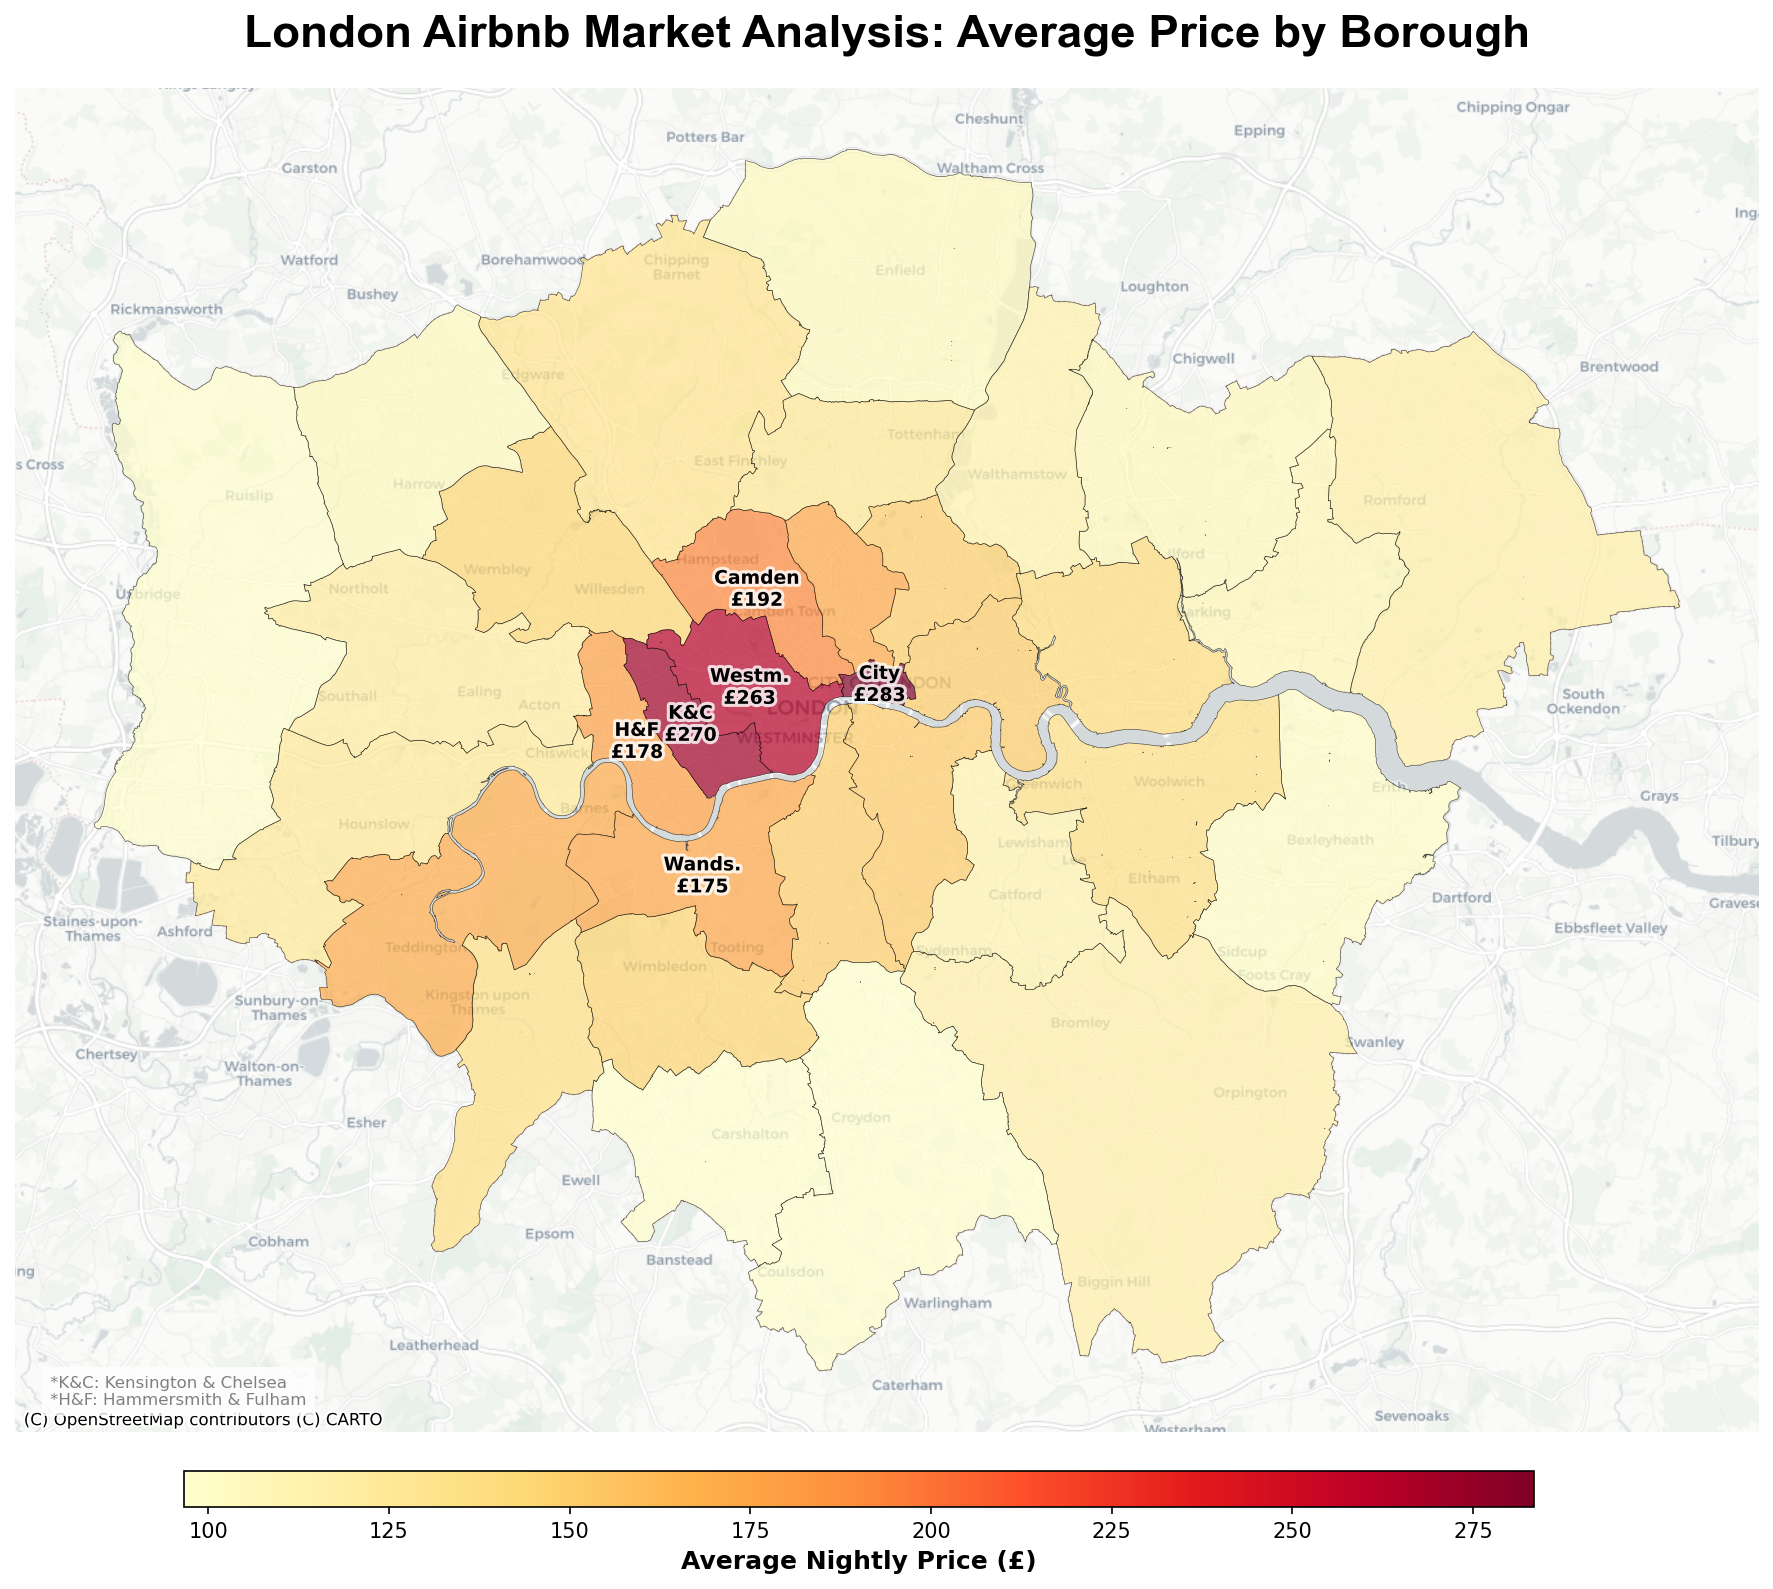

In [33]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as PathEffects


# --- 5. Visualisation: Professional Map with Abbreviated Labels ---
print("Generating professional map with abbreviated labels...")

# 1. Setup Canvas
fig, ax = plt.subplots(1, 1, figsize=(15, 12), dpi=150)

# 2. Reproject to Web Mercator (EPSG:3857) for Basemap compatibility
london_map_web = london_map.to_crs(epsg=3857)

# 3. Plot Choropleth Layer
london_map_web.plot(column='avg_price',
                    ax=ax,
                    cmap='YlOrRd', 
                    edgecolor='black',
                    linewidth=0.3,
                    alpha=0.7)

# 4. Add Basemap (CartoDB Positron)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=11)

# 5. Define Abbreviations Dictionary
# Solves the issue of long names overlapping in the city centre
short_names = {
    'Kensington and Chelsea': 'K&C',
    'City of London': 'City',
    'Hammersmith and Fulham': 'H&F',
    'Richmond upon Thames': 'Richmond',
    'Westminster': 'Westm.',
    'Camden': 'Camden',
    'Islington': 'Islington',
    'Wandsworth': 'Wands.'
}

# 6. Add Smart Labels
# Label only the Top 6 boroughs to prevent overcrowding
top_boroughs = london_map_web.sort_values(by='avg_price', ascending=False).head(6)

for x, y, label, price in zip(top_boroughs.geometry.centroid.x, 
                              top_boroughs.geometry.centroid.y, 
                              top_boroughs['name'],
                              top_boroughs['avg_price']):
    
    # Use abbreviation if available, else use full name
    display_name = short_names.get(label, label)
    
    # Render Text
    txt = ax.text(x, y, f"{display_name}\n£{price:.0f}", 
                  fontsize=9,
                  ha='center', 
                  va='center',
                  fontweight='bold', 
                  color='black')
    
    # Add white outline for readability against dark colours
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white', alpha=0.8)])

# 7. Add Colorbar
cax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                           norm=plt.Normalize(vmin=london_map_web['avg_price'].min(), 
                                              vmax=london_map_web['avg_price'].max()))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Average Nightly Price (£)', fontsize=12, fontweight='bold')

# 8. Title and Footnotes
ax.set_title('London Airbnb Market Analysis: Average Price by Borough', 
             fontsize=22, fontweight='bold', pad=20, fontname='Arial')

# Add footnote to explain abbreviations
ax.text(0.02, 0.02, "*K&C: Kensington & Chelsea\n*H&F: Hammersmith & Fulham", 
        transform=ax.transAxes, fontsize=8, color='gray', 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax.set_axis_off()

plt.show()

### 6 Strategic Investment Analysis (Cost vs. Demand)

Identifying "expensive" areas is not enough. Investors need to find areas with **high demand** and **growth potential**.

We construct a **Price-Demand Matrix** (Scatter Plot):
* **X-Axis:** Average Price (Cost of Entry).
* **Y-Axis:** Average Review Count (Proxy for Occupancy/Popularity).

**Strategic Quadrants:**
* **Top-Left (High Potential):** Boroughs like *Lambeth* or *Islington*. Lower entry price but higher tourist engagement than average. These represent the "Sweet Spot" for ROI.
* **Top-Right (Premium):** *Westminster*. High cost, high demand. Stable but expensive.
* **Outlier:** *Richmond upon Thames*. Exceptionally high satisfaction/engagement, suggesting a niche market for experience-driven tourism.

Analysing price vs. popularity...


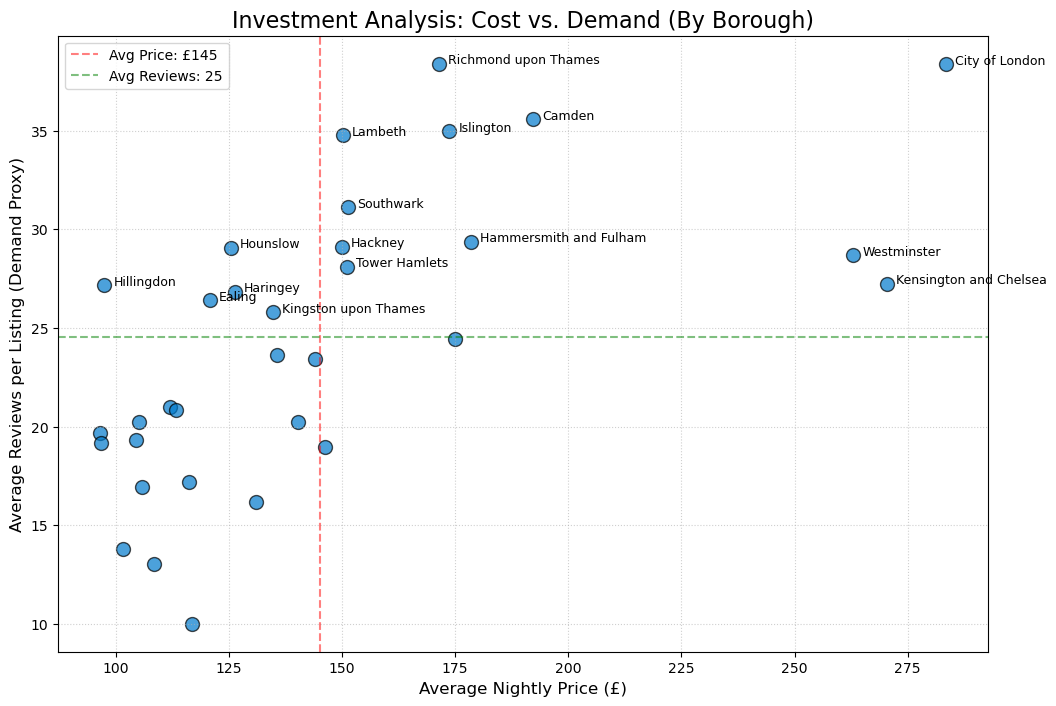

In [35]:
# --- 6. Business Insight: Price vs. Popularity Analysis ---

print("Analysing price vs. popularity...")

# Aggregating data by borough
analysis = gdf.groupby('neighbourhood_cleansed').agg({
    'price': 'mean',
    'number_of_reviews': 'mean' 
}).reset_index()

# Setup Scatter Plot
plt.figure(figsize=(12, 8))

plt.scatter(analysis['price'], analysis['number_of_reviews'], 
            c='#007acc', s=100, alpha=0.7, edgecolors='black')

# Add Average Lines (Quadrants)
avg_price_london = analysis['price'].mean()
avg_review_london = analysis['number_of_reviews'].mean()

plt.axvline(avg_price_london, color='red', linestyle='--', alpha=0.5, label=f'Avg Price: £{avg_price_london:.0f}')
plt.axhline(avg_review_london, color='green', linestyle='--', alpha=0.5, label=f'Avg Reviews: {avg_review_london:.0f}')

# Label Logic: Highlight interesting data points only
for i, row in analysis.iterrows():
    # Logic: Label if > £200 OR > 25 Reviews OR High Value (Cheap but popular)
    if row['price'] > 200 or row['number_of_reviews'] > 25 or (row['price'] < 100 and row['number_of_reviews'] > 20):
        plt.text(row['price']+2, row['number_of_reviews'], row['neighbourhood_cleansed'], fontsize=9)

plt.title("Investment Analysis: Cost vs. Demand (By Borough)", fontsize=16)
plt.xlabel("Average Nightly Price (£)", fontsize=12)
plt.ylabel("Average Reviews per Listing (Demand Proxy)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

# Phase 2: Unsupervised Machine Learning (Clustering)
### Market Segmentation using K-Means

**Business Objective:**
Moving beyond geographical boundaries, we aim to categorize listings based on their **behavioural and financial characteristics**. This helps investors understand the distinct "product types" in the market (e.g., "Budget Crashpads" vs "Premium Holiday Homes").

**Methodology:**
1.  **Data Cleaning & Pre-processing:**
    * **Outlier Removal:** We filter out listings priced over £1,000 to prevent extreme luxury assets from skewing the model.
    * **Feature Selection:** We select `price`, `minimum_nights`, `number_of_reviews`, and `availability_365`.
2.  **Standardisation:**
    * K-Means is distance-based. Since `price` (e.g., £150) has a much larger range than `minimum_nights` (e.g., 2), we use `StandardScaler` to normalise all features to the same scale.
3.  **The Elbow Method:**
    * To determine the optimal number of clusters ($K$), we calculate the Within-Cluster Sum of Squares (WCSS) for $K=1$ to $K=10$. We look for the "elbow" point where the variance reduction diminishes.

Status: Preparing data for clustering...
Status: Removed extreme outliers. Clustering on 61151 listings.
Status: Running Elbow Method to find optimal clusters...


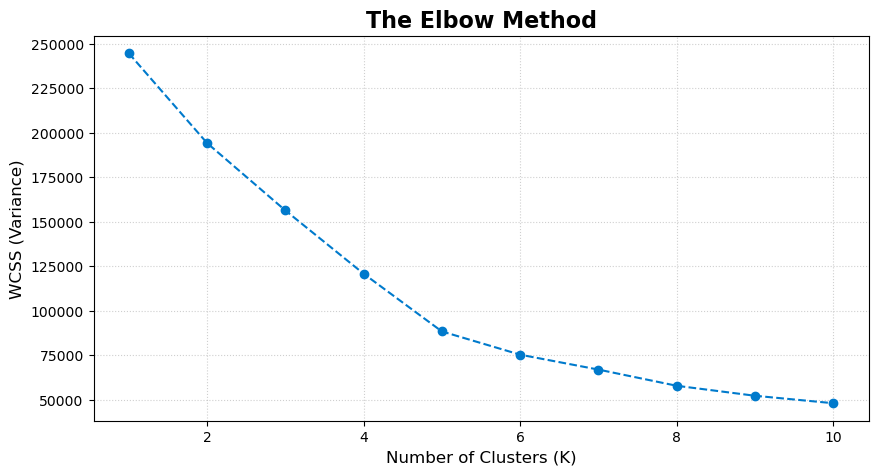

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# --- 7. Machine Learning: Data Preparation ---
print("Status: Preparing data for clustering...")

features = ['price', 'minimum_nights', 'number_of_reviews', 'availability_365']

# Critical Fix: Filter out extreme outliers
# We only retain listings under £1000 to ensure the model focuses on the mass market.
# We also ensure price is positive.
df_filtered = df[(df['price'] < 1000) & (df['price'] > 0)].copy()

# Extract features and drop any remaining null values
df_ml = df_filtered[features].dropna()

print(f"Status: Removed extreme outliers. Clustering on {len(df_ml)} listings.")

# 2. Standardisation (Crucial for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ml)

# 3. The Elbow Method (Finding the optimal 'K')
# We test cluster counts from 1 to 10 to see which fits best
print("Status: Running Elbow Method to find optimal clusters...")
wcss = [] # Within-Cluster Sum of Square
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='#007acc')
plt.title('The Elbow Method', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Variance)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

### 8 Model Training & Interpretation

Based on the Elbow Plot, the curve begins to flatten significantly at **$K=5$**. This suggests that the London market naturally divides into five distinct segments.

**Visualisation:**
We utilise a **Pairplot** to visualise the separation between clusters. This allows us to see which features (e.g., Availability or Price) are responsible for driving the differences between groups.

Training K-Means model with K=5...

✅ Market Segmentation Results (Average values per cluster):
         price  minimum_nights  number_of_reviews  availability_365  Count
Cluster                                                                   
0        136.1             3.9               20.7              87.7  23559
1        137.4             4.4               16.5             311.3  28787
2        103.4             2.4              247.3             200.8   2490
3        503.7             5.5               13.7             245.9   6144
4        158.1           274.4               11.0             292.3    171
Generating Pairplot visualisation...


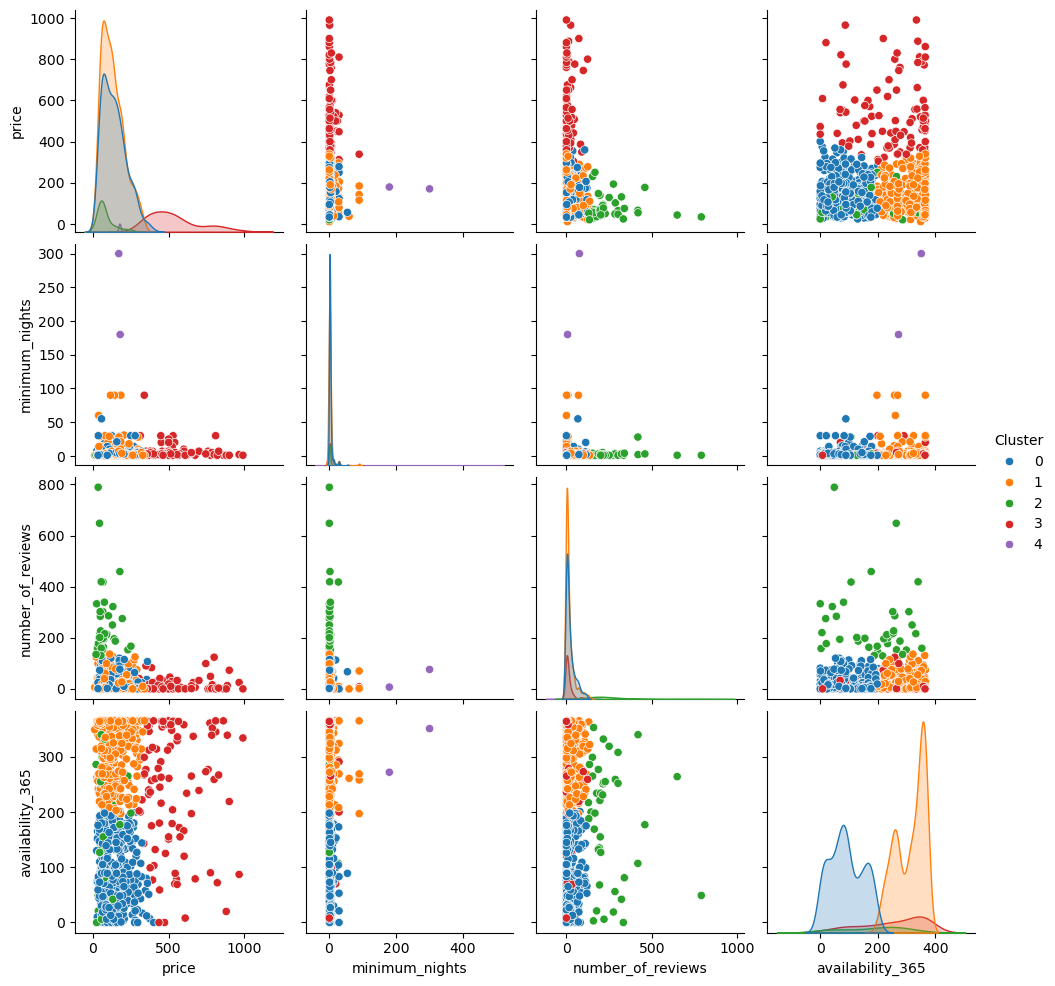


Final Cluster Summary Table:
         price  minimum_nights  number_of_reviews  availability_365  Count
Cluster                                                                   
0        136.1             3.9               20.7              87.7  23559
1        137.4             4.4               16.5             311.3  28787
2        103.4             2.4              247.3             200.8   2490
3        503.7             5.5               13.7             245.9   6144
4        158.1           274.4               11.0             292.3    171


In [47]:
# --- 8. Running K-Means & Business Interpretation ---
print("Training K-Means model with K=5...")

# 1. Train Model (Selected K=5 based on the Elbow plot analysis)
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 2. Add labels back to the original DataFrame
df_ml['Cluster'] = cluster_labels

# 3. Interpret the Clusters
# Calculate the mean of each feature for every cluster
# .round(1) keeps the output clean
cluster_summary = df_ml.groupby('Cluster').mean().round(1)

# Add a 'Count' column to analyse market share
cluster_summary['Count'] = df_ml['Cluster'].value_counts()

print("\n✅ Market Segmentation Results (Average values per cluster):")
print(cluster_summary)

# 4. Visualisation: Pairplot to see the separation
# Sampling 1000 points ensures the plot renders quickly
print("Generating Pairplot visualisation...")
sample_plot = df_ml.sample(1000, random_state=42)
sns.pairplot(sample_plot, hue='Cluster', palette='tab10', vars=features)
plt.show()

# Create a final summary table for the report
summary = df_ml.groupby('Cluster').agg({
    'price': 'mean',
    'minimum_nights': 'mean',
    'number_of_reviews': 'mean',
    'availability_365': 'mean',
    'Cluster': 'count' # Count how many listings in each group
}).rename(columns={'Cluster': 'Count'}).round(1)

print("\nFinal Cluster Summary Table:")
print(summary)

### 📊 Final Interpretation: The 5 Personas of London Hosting

By analysing the Cluster Summary Table, we have decoded the London market into 5 actionable personas. This resolves the problem of treating the market as a monolith.

| Cluster | Persona Name | Key Characteristic | Business Insight |
| :--- | :--- | :--- | :--- |
| **0** | **The Occasional Sharers** | Low Availability (~88 days) | Genuine residents renting whilst away. Compliant with the 90-day regulation. Low risk, passive income. |
| **1** | **The Commercial Ops** | High Availability (~311 days) | Full-time business operations. High volume but significant regulatory risk regarding planning permission. |
| **2** | **The Budget Kings** | High Reviews (240+) | The most efficient segment. Low price (£103) drives massive occupancy. High turnover strategy. |
| **3** | **The Premium Tier** | High Price (£500+) | Luxury assets. A niche market (low count) targeting high-net-worth travellers. |
| **4** | **The Long-Term Lets** | High Min Nights (~274) | Residential tenancies using Airbnb for advertising. Not part of the short-term tourism market. |

**Conclusion:**
For a new investor, **Cluster 2 (Budget Kings)** demonstrates the highest market engagement, suggesting that a competitive pricing strategy yields the best occupancy. However, **Cluster 0** offers the safest route for regulatory compliance.